## TEMPORAL ANALYSIS OF USER ACTIVITY

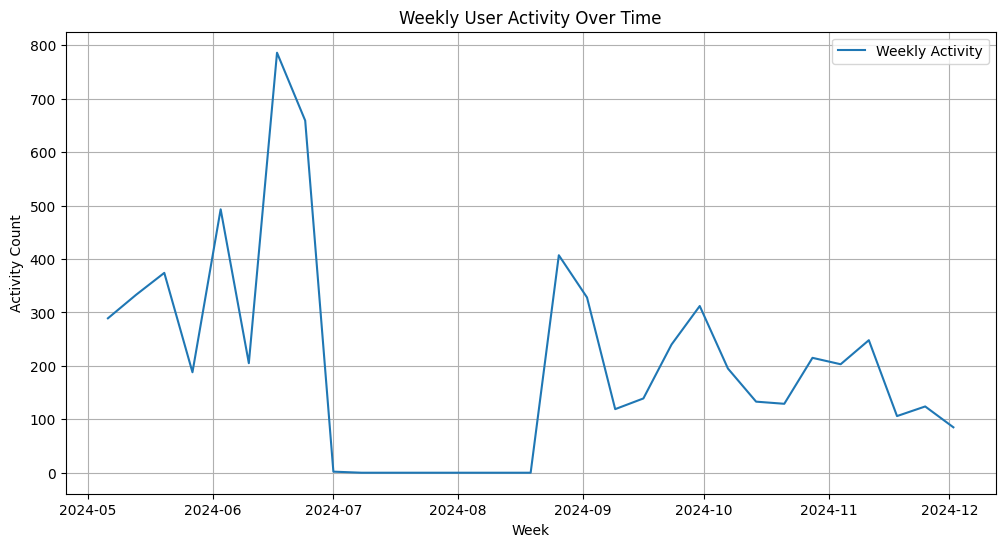

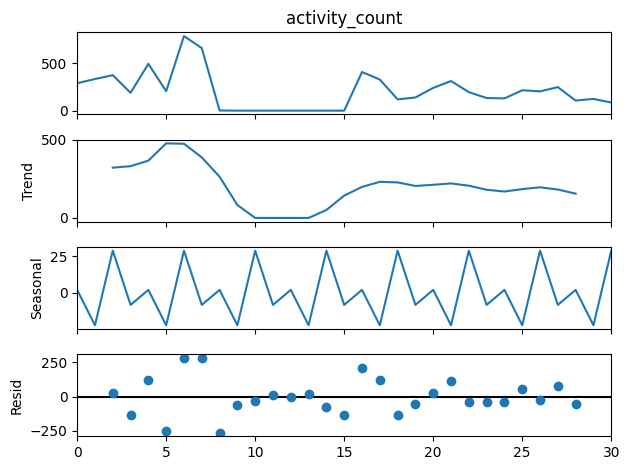

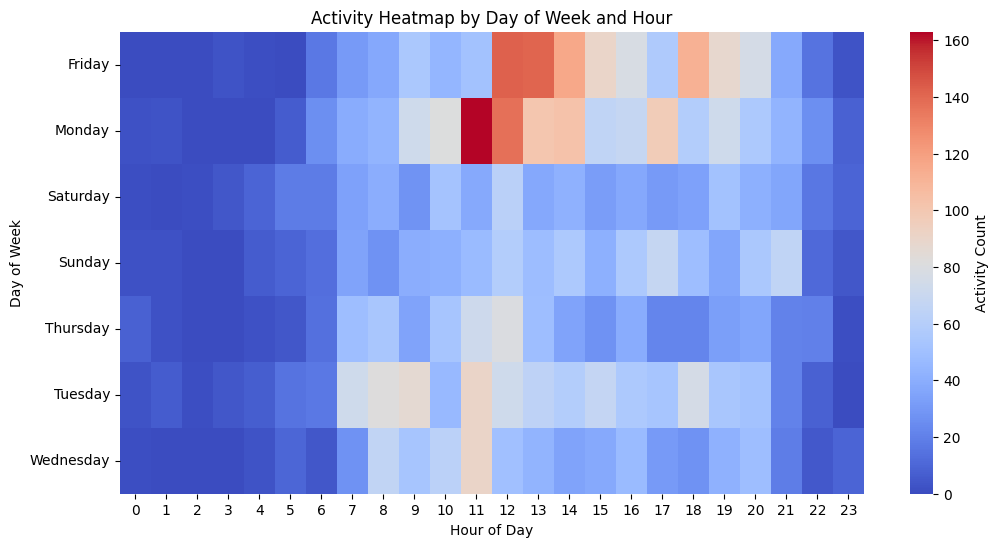

21:11:17 - cmdstanpy - INFO - Chain [1] start processing
21:11:17 - cmdstanpy - INFO - Chain [1] done processing


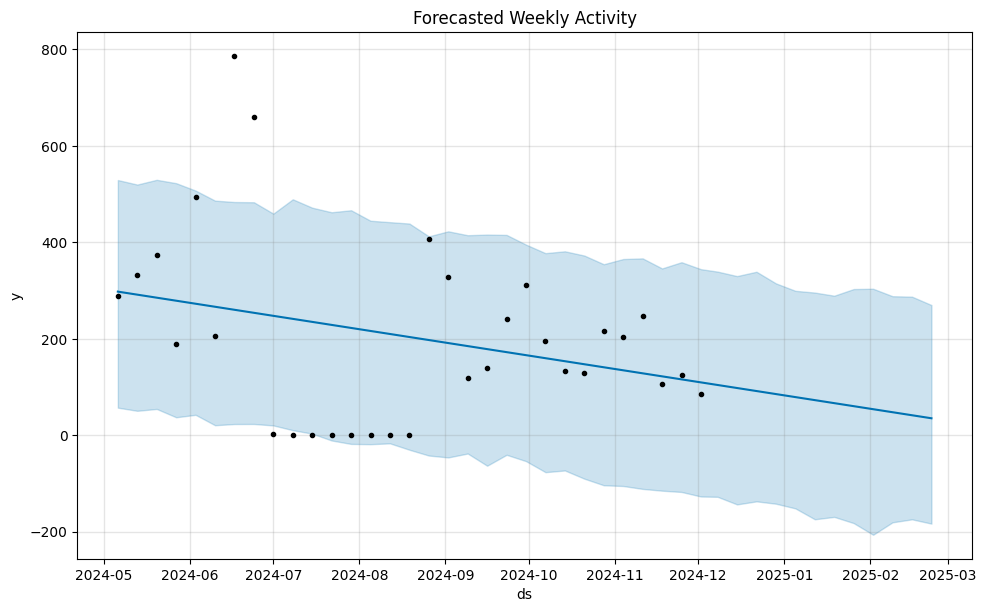

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

# Load the dataset
data = pd.read_csv('./data/data.csv')

# Convert Unix timestamps to datetime and handle null values
date_columns = ['CourseModuleCompletion', 'CourseCompletionStart', 'CourseCompletionFinish']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], unit='s', errors='coerce')

# Filter out rows where the date is Unix timestamp 0 (corresponds to 1970-01-01)
for col in date_columns:
    data = data[data[col] != pd.Timestamp('1970-01-01')]

# Create a single activity date column, using completion and start dates as proxies
data['activity_date'] = data['CourseModuleCompletion'].combine_first(data['CourseCompletionStart'])

# Drop rows where no date is available
data = data.dropna(subset=['activity_date'])

# Aggregate activity by day
daily_activity = data.groupby(data['activity_date'].dt.date).size().reset_index(name='activity_count')
daily_activity['activity_date'] = pd.to_datetime(daily_activity['activity_date'])

# Fill missing dates in the time range with zero activity
full_date_range = pd.date_range(start=daily_activity['activity_date'].min(), 
                                end=daily_activity['activity_date'].max(), freq='D')
daily_activity = daily_activity.set_index('activity_date').reindex(full_date_range, fill_value=0).reset_index()
daily_activity.columns = ['date', 'activity_count']

# Aggregate by week for smoother trends
daily_activity['week'] = daily_activity['date'].dt.to_period('W')
weekly_activity = daily_activity.groupby('week')['activity_count'].sum().reset_index()
weekly_activity['week'] = weekly_activity['week'].dt.start_time

# Plot weekly activity trends
plt.figure(figsize=(12, 6))
plt.plot(weekly_activity['week'], weekly_activity['activity_count'], label='Weekly Activity')
plt.title('Weekly User Activity Over Time')
plt.xlabel('Week')
plt.ylabel('Activity Count')
plt.grid()
plt.legend()
plt.show()

# Decompose the time series to observe trend and seasonality
decomposition = seasonal_decompose(weekly_activity['activity_count'], model='additive', period=4)
decomposition.plot()
plt.show()

# Analyze activity patterns by hour of the day and day of the week
data['hour'] = data['activity_date'].dt.hour
data['day_of_week'] = data['activity_date'].dt.day_name()

heatmap_data = data.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Activity Count'})
plt.title('Activity Heatmap by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Forecast future activity using Prophet
prophet_data = weekly_activity.rename(columns={'week': 'ds', 'activity_count': 'y'})
model = Prophet()
model.fit(prophet_data)

future = model.make_future_dataframe(periods=12, freq='W')  # Forecast 12 weeks into the future
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecasted Weekly Activity')
plt.show()
